In [1]:
import torch
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import time

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
train_data = np.load('/kaggle/input/distracted-driver/train_statefarm_images.npz')
test_data = np.load('/kaggle/input/distracted-driver/test_statefarm_images.npz')
X_train = train_data['X']
y_train = train_data['y']
X_test = test_data['X']
y_test = test_data['y']

print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Train targets shape: {y_train.shape}")
print(f"Test targets shape: {y_test.shape}")

Train set shape: (17939, 64, 64, 3)
Test set shape: (4485, 64, 64, 3)
Train targets shape: (17939,)
Test targets shape: (4485,)


In [4]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"\nFlattened train shape: {X_train_flat.shape}")
print(f"Flattened test shape: {X_test_flat.shape}")
print(f"Number of features: {X_train_flat.shape[1]}")
print(f"Number of classes: {len(np.unique(y_train))}")


Flattened train shape: (17939, 12288)
Flattened test shape: (4485, 12288)
Number of features: 12288
Number of classes: 8


In [5]:
from sklearn.model_selection import train_test_split

# Combine train and test data
X_combined = torch.cat([torch.tensor(X_train), torch.tensor(X_test)], dim=0)
y_combined = torch.cat([torch.tensor(y_train), torch.tensor(y_test)], dim=0)

print(f"\nCombined data shape: {X_combined.shape}")
print(f"Combined targets shape: {y_combined.shape}")

# Convert to numpy for stratified split
X_combined_np = X_combined.numpy()
y_combined_np = y_combined.numpy()

# Create stratified train-test split (80-20)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_combined_np, 
    y_combined_np, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_combined_np
)

# Convert back to torch tensors
X_train = torch.from_numpy(X_train_new)
X_test = torch.from_numpy(X_test_new)
y_train = torch.from_numpy(y_train_new)
y_test = torch.from_numpy(y_test_new)

print(f"\nNew train set shape: {X_train.shape}")
print(f"New test set shape: {X_test.shape}")
print(f"New train targets shape: {y_train.shape}")
print(f"New test targets shape: {y_test.shape}")


Combined data shape: torch.Size([22424, 64, 64, 3])
Combined targets shape: torch.Size([22424])

New train set shape: torch.Size([17939, 64, 64, 3])
New test set shape: torch.Size([4485, 64, 64, 3])
New train targets shape: torch.Size([17939])
New test targets shape: torch.Size([4485])


In [6]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"\nFlattened train shape: {X_train_flat.shape}")
print(f"Flattened test shape: {X_test_flat.shape}")
print(f"Number of features: {X_train_flat.shape[1]}")
print(f"Number of classes: {len(np.unique(y_train))}")


Flattened train shape: torch.Size([17939, 12288])
Flattened test shape: torch.Size([4485, 12288])
Number of features: 12288
Number of classes: 10


In [7]:
print("Training Decision Tree Classifier...")
start_time = time.time()

dt_classifier = DecisionTreeClassifier(
    random_state=42,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5
)

dt_classifier.fit(X_train_flat, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

Training Decision Tree Classifier...
Training completed in 266.31 seconds


In [9]:
import joblib

print("\nMaking predictions...")
y_train_pred = dt_classifier.predict(X_train_flat)
y_test_pred = dt_classifier.predict(X_test_flat)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

joblib.dump(dt_classifier, "decision_tree_model.pkl")


Making predictions...
Train Accuracy: 0.8527
Test Accuracy: 0.7741


['decision_tree_model.pkl']

In [10]:
print("\n" + "="*50)
print("CLASSIFICATION REPORT - TEST SET")
print("="*50)
print(classification_report(y_test, y_test_pred))


CLASSIFICATION REPORT - TEST SET
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       498
           1       0.82      0.69      0.75       453
           2       0.55      0.83      0.66       464
           3       0.86      0.80      0.83       469
           4       0.86      0.84      0.85       465
           5       0.94      0.87      0.91       463
           6       0.58      0.75      0.66       465
           7       0.88      0.76      0.82       400
           8       0.87      0.68      0.76       382
           9       0.80      0.70      0.75       426

    accuracy                           0.77      4485
   macro avg       0.80      0.77      0.78      4485
weighted avg       0.80      0.77      0.78      4485



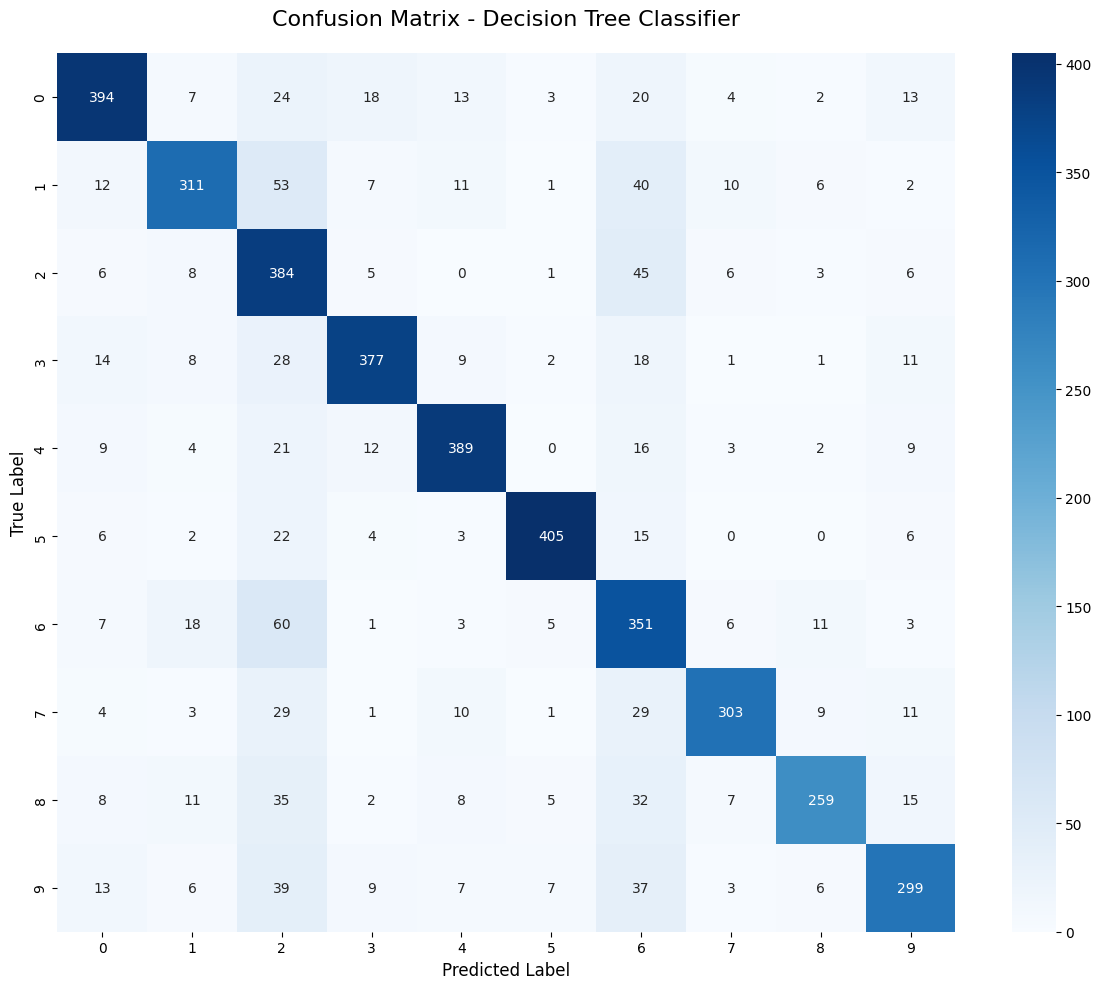

In [11]:
# Get unique classes
classes = np.unique(y_train)
n_classes = len(classes)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Decision Tree Classifier', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [12]:
print("\n" + "="*50)
print("PER-CLASS PERFORMANCE")
print("="*50)

for class_idx in classes:
    class_mask = y_test == class_idx
    class_accuracy = accuracy_score(
        y_test[class_mask], 
        y_test_pred[class_mask]
    )
    n_samples = class_mask.sum().item()
    print(f"Class {class_idx}: Accuracy = {class_accuracy:.4f} (n={n_samples})")


PER-CLASS PERFORMANCE
Class 0: Accuracy = 0.7912 (n=498)
Class 1: Accuracy = 0.6865 (n=453)
Class 2: Accuracy = 0.8276 (n=464)
Class 3: Accuracy = 0.8038 (n=469)
Class 4: Accuracy = 0.8366 (n=465)
Class 5: Accuracy = 0.8747 (n=463)
Class 6: Accuracy = 0.7548 (n=465)
Class 7: Accuracy = 0.7575 (n=400)
Class 8: Accuracy = 0.6780 (n=382)
Class 9: Accuracy = 0.7019 (n=426)
